In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project/Simple_model
/home/ladans/DNN/Project/Simple_model/Dataset


In [3]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, BatchNormalization
from keras.layers import Flatten, RepeatVector

# Directory containing CSV files
data_dir = dir_base

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    # Extract stock symbol from the filename
    stock_symbol = os.path.basename(file_path).split('.')[0]
    
    # Load the CSV
    df = pd.read_csv(file_path)
    
    # Add a column for the stock symbol
    df['Stock_Symbol'] = stock_symbol
    
    # Optional: Select only necessary columns
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    
    # Append to the main DataFrame
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol if needed
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])
all_data.head()

2024-11-23 19:02:18.766277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732388538.790544  267340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732388538.798155  267340 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 19:02:18.825308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Date,Open,Close,Stock_Symbol,Stock_Index
0,2012-09-04,95.108574,96.424286,AAPL,0
1,2012-09-05,96.510002,95.747147,AAPL,0
2,2012-09-06,96.167145,96.610001,AAPL,0
3,2012-09-07,96.864288,97.205711,AAPL,0
4,2012-09-10,97.207146,94.677139,AAPL,0


In [4]:
# Parameters
sequence_length = 30  # Days in each input sequence
#test_ratio = 0.2

# Initialize lists for inputs and outputs
X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    
    # Normalize 'Close' price data for this stock
    prices = stock_data['Close'].values
    normalized_prices = prices / prices[0] - 1  # Normalize with respect to the first value
    
    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])  # Same index for the whole stock

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)

# Train-test split
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
train_size = int(len(X) * train_ratio)
validation_size = int(len(X) * validation_ratio)

# Perform the splits
X_train = X[:train_size]
y_train = y[:train_size]
stock_indices_train = stock_indices[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]
stock_indices_val = stock_indices[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]
stock_indices_test = stock_indices[train_size + validation_size:]

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print sizes for verification
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 3438
Validation samples: 736
Test samples: 738


In [5]:
#Model:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size = 8

# Define inputs
price_input = Input(shape=(sequence_length, 1), name='price_input')
stock_input = Input(shape=(1,), name='stock_input')


# Embedding layer for stock index
stock_embedding = Embedding(input_dim=num_stocks, output_dim=embedding_size, input_length=1)(stock_input)
stock_embedding = Flatten()(stock_embedding)  # Flatten to 2D (batch_size, embedding_size)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)  # Replicate to match LSTM input shape

# Concatenate price input with stock embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])


# LSTM layer
lstm_out = LSTM(units=256)(merged_input)
lstm_out = Dropout(0.3)(lstm_out)

# Output layer
output = Dense(units=1)(lstm_out)

# Define and compile the model
model = Model(inputs=[price_input, stock_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([X_train, stock_indices_train], y_train,
    validation_data=([X_val, stock_indices_val], y_val),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30


W0000 00:00:1732388540.986107  267340 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0351 - val_loss: 0.0019
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 3/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 4/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 5/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0049 - val_loss: 9.3744e-04
Epoch 6/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 7/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 8/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 9/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 10/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0050 - val_loss: 7.1722e-04
Epoch 11/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0044 - val_loss: 6.6408e-04
Epoch 12/30
215/215 ━━━━━━━━━━━━━━━━━━━━

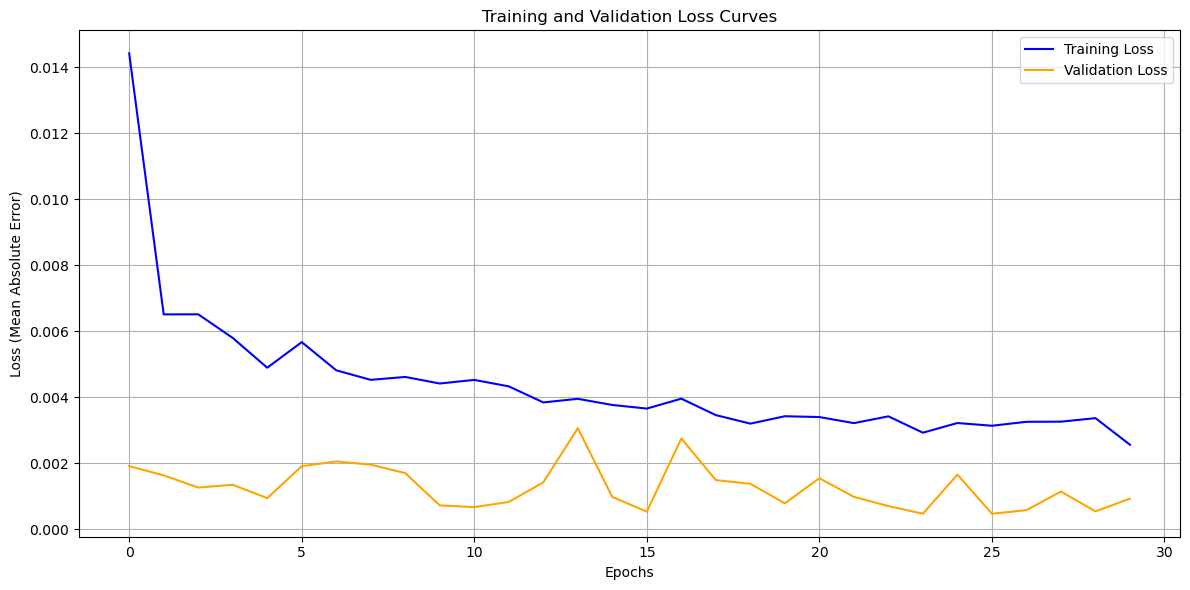

In [11]:
import matplotlib.pyplot as plt

# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('train_val')
plt.show()


In [7]:
# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


MAE: 0.7701345513912707
MSE: 0.9674248687103362
RMSE: 0.9835775865229627
MAPE: 18.79192866725641 %


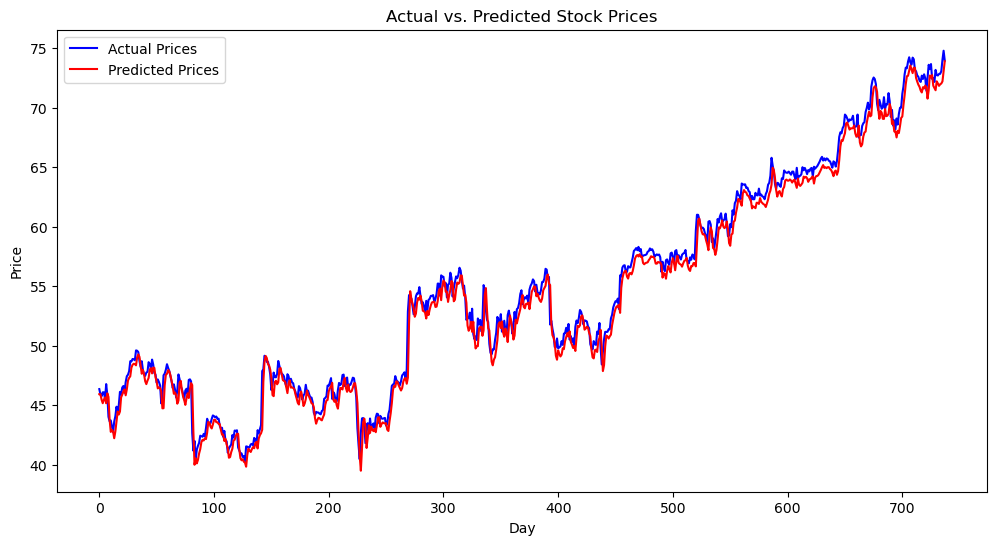

In [10]:
#Denormalized Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reverse normalize predictions and actual prices
reversed_actual_prices = []
reversed_predicted_prices = []

# Loop through each stock in the test set
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    
    # Extract the first price for this stock in the test set
    first_price = all_data[all_data['Stock_Symbol'] == stock_symbol]['Close'].iloc[0]
    
    # Reverse normalize
    reversed_actual = (y_test[stock_mask] + 1) * first_price
    reversed_predicted = (predicted_prices[stock_mask] + 1) * first_price
    
    reversed_actual_prices.extend(reversed_actual)
    reversed_predicted_prices.extend(reversed_predicted)

# Convert lists to numpy arrays for further evaluation
reversed_actual_prices = np.array(reversed_actual_prices)
reversed_predicted_prices = np.array(reversed_predicted_prices)

# Calculate metrics with reversed prices
mae_reversed = mean_absolute_error(reversed_actual_prices, reversed_predicted_prices)
mse_reversed = mean_squared_error(reversed_actual_prices, reversed_predicted_prices)
rmse_reversed = mean_squared_error(reversed_actual_prices, reversed_predicted_prices, squared=False)
mape_reversed = np.mean(np.abs((reversed_actual_prices - reversed_predicted_prices) / reversed_actual_prices)) * 100

# Print results
print("MAE:", mae_reversed)
print("MSE:", mse_reversed)
print("RMSE:", rmse_reversed)
print("MAPE:", mape_reversed, "%")

# Plot reversed actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(reversed_actual_prices, label="Actual Prices", color="blue")
plt.plot(reversed_predicted_prices, label="Predicted Prices", color="red")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.savefig('Simple model plot')
plt.show()

# Evaluate per-stock metrics
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae_reversed = mean_absolute_error(
        reversed_actual_prices[stock_mask], reversed_predicted_prices[stock_mask]
    )

In [ ]:
# Predict the next price for a new sequence
array_30_values = X_test[-1]

# Reshape new_sequence to match the model's expected input shape
new_sequence = array_30_values.reshape((1, sequence_length, 1))

# Find the encoded index for the desired stock
stock_index = encoder.transform(['MSFT'])
# Predict the normalized price
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization
original_starting_price = all_data[(all_data['Stock_Symbol'] == 'MSFT')]['Close'].values[0]
predicted_price_original_scale = (predicted_normalized_price[0][0] + 1) * original_starting_price

print("Predicted next price for MSFT (original scale):", predicted_price_original_scale)


Predicted next price for MSFT (original scale): 74.75694246109748